In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host='localhost',
                             user='root',
                             password='Harsh@sql',
                             database='ecommerce')

cur = db.cursor()

## Q1. List all unique cities where customers are located.

In [91]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['City'])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Q2. Count the number of orders placed in 2017.

In [22]:
query = """select count(order_id) from orders where YEAR(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

'Total number of orders placed in 2017 ',data[0][0]

('Total number of orders placed in 2017 ', 45101)

## Q3. Find the total sales per category.

In [34]:
query = """select p.product_category category, round(sum(payments.payment_value),2) sales from products p 
join order_items o
on p.product_id = o.product_id
join payments 
on payments.order_id = o.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


## Q4. Calculate the percentage of orders that were paid in installments.

In [42]:
# query = """select (sum(case when payment_installments >= 1 then 1 else 0 end)/count(*))*100 from payments"""
query = """select (((select count(order_id) from payments where payment_installments >= 1))/count(order_id))*100 from payments"""
cur.execute(query)

data = cur.fetchall()
'The percentage of orders that were paid in installments is', data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Q5. Count the number of customers from each state. 

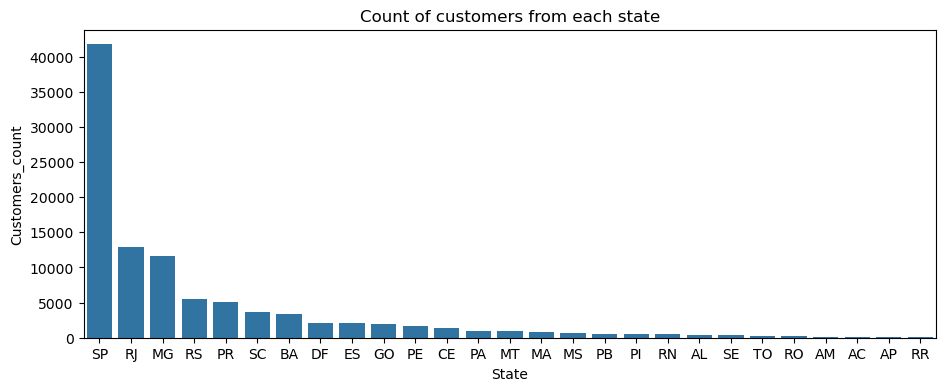

In [150]:
query = """select customer_state, count(customer_id) from customers 
group by customer_state"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['State','Customers_count'])

df = df.sort_values(by = 'Customers_count', ascending=False)
# print(df)

plt.figure(figsize=(11,4))
sns.barplot(x = df['State'],y = df['Customers_count'])
# plt.xticks(rotation = 90)
plt.title('Count of customers from each state')
plt.show()

## Q6. Calculate the number of orders per month in 2018.

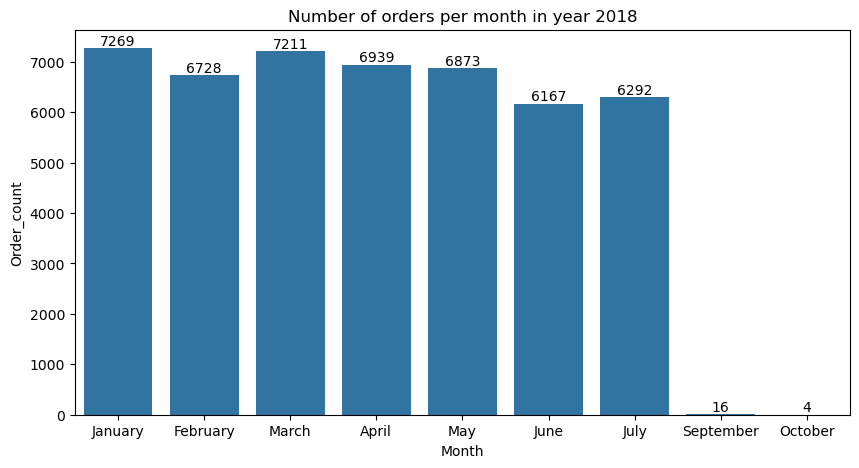

In [152]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where YEAR(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month','Order_count'])
o = ["January","February","March","April","May","June","July","September","October"]

plt.figure(figsize=(10,5))
ax = sns.barplot(x = df['Month'],y = df['Order_count'], order = o)
ax.bar_label(ax.containers[0])
plt.title('Number of orders per month in year 2018')
plt.show()

## Q7. Find the average number of products per order, grouped by customer city.

In [177]:
query = """with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc), 2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer_city','Average_products_per_order'])
df.head(10)

,Customer_city,Average_products_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


## Q8. Calculate the percentage of total revenue contributed by each product category.

In [179]:
query = """select p.product_category category, round((sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100, 2) sales from products p 
join order_items o
on p.product_id = o.product_id
join payments 
on payments.order_id = o.order_id
group by category order by sales desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category','Sales Percentage'])
df.head(10)

,Category,Sales Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


## Q9. Identify the correlation between product price and the number of times a product has been purchased.

In [195]:
query = """select products.product_category, count(order_items.product_id) number_of_orders, round(avg(order_items.price), 2) average_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category','Order_count','Average_price'])

arr1 = df['Order_count']
arr2 = df['Average_price']

print(np.corrcoef([arr1,arr2]))
print('\n The value 0.106 indicates that there is no correlation between product price and the number of times a product has been purchased')

[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]

 The value 0.106 indicates that there is no correlation between product price and the number of times a product has been purchased


## Q10. Calculate the total revenue generated by each seller, and rank them by revenue.

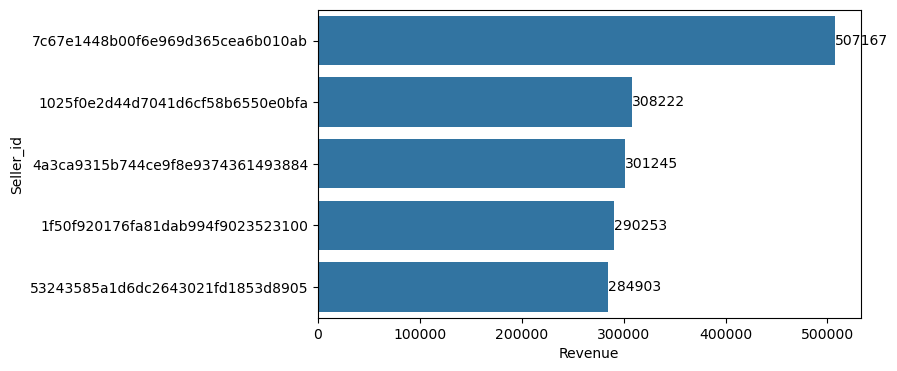

In [17]:
query = """select order_items.seller_id, round(sum(payments.payment_value),2) revenue, rank() over (order by round(sum(payments.payment_value)) desc) ranks
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id
order by revenue desc"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_id','Revenue','Rank'])
top = df.head(5)

plt.figure(figsize=(7,4))
ax = sns.barplot(x = top['Revenue'], y = top['Seller_id'], data = top, orient = 'h')
ax.bar_label(ax.containers[0])
# plt.xticks(rotation=90)
plt.show()

## Q11. Calculate the moving average of order values for each customer over their order history.

In [19]:
query = """select customer_id, order_purchase_timestamp, 
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_id','Date','Mov_avg'])
df

,Customer_id,Date,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


## Q12. Calculate the cumulative sales per month for each year.

In [35]:
query = """select years,months,sales,round(sum(sales) over(order by years,months),2) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as sales
from payments join orders
on payments.order_id = orders.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Year','Month','Sales','Cumulative Sales'])
df


,Year,Month,Sales,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## Q13. Calculate the year-over-year growth rate of total sales.

In [37]:
query = """select years, ((sales - lag(sales,1) over(order by years))/lag(sales,1) over(order by years))*100 as growth_rate
from
(select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as sales
from payments join orders
on payments.order_id = orders.order_id
group by years order by years) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Year','yoy % growth'])
df

,Year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## Q14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [39]:
query = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 24 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

## Q15. Identify the top 3 customers who spent the most money in each year.

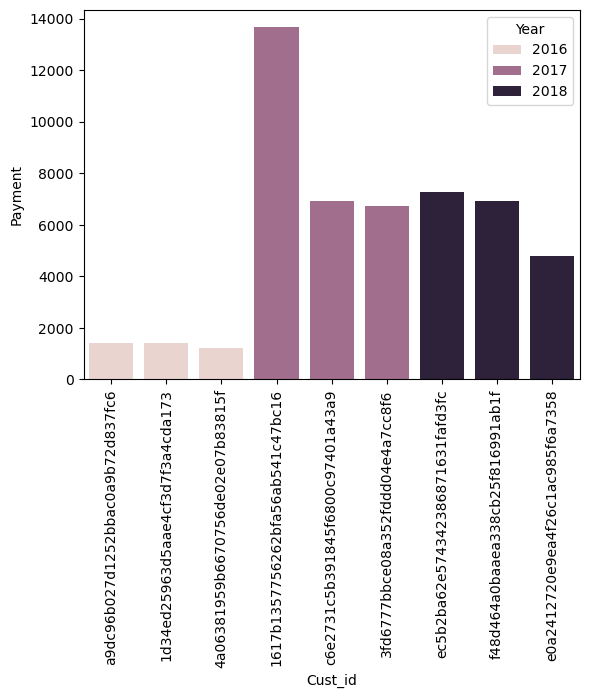

In [43]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by years, orders.customer_id) as a
where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Year','Cust_id','Payment','Rank'])
sns.barplot(x = 'Cust_id', y = 'Payment', data = df, hue = 'Year')
plt.xticks(rotation=90)
plt.show()